# Workshop 8. Наивный Байес и Классификация текстов

> Байесовские алгоритмы для классификации текстов  
> Извлечение признаков из текста

1. Скачайте этот ноутбук к себе.
2. Заполните пропущенные ячейки, отвечая на заданные вопросы. Там должен быть код! (если не сказано обратное)
3. Сохраните результат в своём гитхаб репозитории.

### Полезная литература

- [Naive Bayes and Text Classification](https://sebastianraschka.com/Articles/2014_naive_bayes_1.html)
- [ODS - классификация](https://habrahabr.ru/company/ods/blog/322534/)
- [Байесовский классификатор](http://www.machinelearning.ru/wiki/index.php?title=%D0%91%D0%B0%D0%B9%D0%B5%D1%81%D0%BE%D0%B2%D1%81%D0%BA%D0%B8%D0%B9_%D0%BA%D0%BB%D0%B0%D1%81%D1%81%D0%B8%D1%84%D0%B8%D0%BA%D0%B0%D1%82%D0%BE%D1%80)
- [Интересная статья про спам/не спам](https://habrahabr.ru/post/252265/)

Если вам понравилась задача распознавания текстов, то вот подборочка:

- [библиотека Gensim](https://radimrehurek.com/gensim/)
- [библиотека nltk](http://www.nltk.org/)
- [Лекция про word2vec 🔥](https://www.youtube.com/watch?v=oBb9aFmp0Hs)
- [Лекция Векторные представления слов и документов 🔥](https://www.youtube.com/watch?v=hiDBnEyoZS4)

## Наивный байесовский классификатор

На практике мы использовали его для детекции спам/не спам. В этот раз вы будете классифицировать [новостные тексты](https://scikit-learn.org/0.19/datasets/twenty_newsgroups.html). Попробуете разные методы  генерации признаков из текстов.

In [1]:
from sklearn.datasets import fetch_20newsgroups
newsgroups_train = fetch_20newsgroups(subset='train', remove=('headers', 'footers', 'quotes'))
newsgroups_train.target_names

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']

### 2.1 Загрузка данных (2 балла)

Мы будем использовать только 4 класса текстов: `'alt.atheism', 'sci.space', 'talk.religion.misc', 'comp.graphics'`.

Загрузите тренировочную и тестовую части датасета для этих категорий.

In [2]:
from sklearn.datasets import fetch_20newsgroups

categories = ['alt.atheism', 'sci.space', 'talk.religion.misc', 'comp.graphics']
newsgroups_train = fetch_20newsgroups(subset='train', categories=categories, remove=('headers', 'footers', 'quotes'))
newsgroups_test = fetch_20newsgroups(subset='test', categories=categories, remove=('headers', 'footers', 'quotes'))

Выведите по 1 тексту для каждой из категории.

In [3]:
for i, category in enumerate(newsgroups_train.target_names):
    idx = next(idx for idx, label in enumerate(newsgroups_train.target) if label == i)
    print(f"Категория: {category}\nТекст: {newsgroups_train.data[idx][:300]}...\n")

Категория: alt.atheism
Текст: I have a request for those who would like to see Charley Wingate
respond to the "Charley Challenges" (and judging from my e-mail, there
appear to be quite a few of you.)  

It is clear that Mr. Wingate intends to continue to post tangential or
unrelated articles while ingoring the Challenges themsel...

Категория: comp.graphics
Текст: Hi,

I've noticed that if you only save a model (with all your mapping planes
positioned carefully) to a .3DS file that when you reload it after restarting
3DS, they are given a default position and orientation.  But if you save
to a .PRJ file their positions/orientation are preserved.  Does anyone
...

Категория: sci.space
Текст: 
 >In article <1993Apr19.020359.26996@sq.sq.com>, msb@sq.sq.com (Mark Brader) 

MB>                                                             So the
MB> 1970 figure seems unlikely to actually be anything but a perijove.

JG>Sorry, _perijoves_...I'm not used to talking this language.

Couldn't we j

### 2.2 Мешок слов

Начнем с самого простого способа извлечения признаков из текстов: обычный подсчет количества употреблений слов в тексте.

Для этого используем [sklearn.feature_extraction.text.CountVectorizer](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html). Настройте его так, чтобы он использовал англиские стоп слова.

Проведите трансформаци текстов из обоих датасетов и выведите размер полученного словаря. (1 векторайзер для тестового и тренировочного датасета! У вас должны получиться матрицы с одинаковыми признаками-словами)

In [4]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Векторизация текста
vec = CountVectorizer(stop_words='english')
X_train_vec = vec.fit_transform(newsgroups_train.data)
X_test_vec = vec.transform(newsgroups_test.data)
y_train = newsgroups_train.target
y_test = newsgroups_test.target

print(f"Размер словаря: {len(vec.get_feature_names_out())}")



Размер словаря: 26576


Будем использовать классифиактор для мультиклассифкации [sklearn.naive_bayes.MultinomialNB]().

- Проведите кроссвалидацию на 5 фолдах для метрики `accuracy`.
- обучите на тренировочных данных, 
- нарисуйте красивую confusion матрицу, (с именами классов, а не индексами по осям)
- выведите отчет классификации для тестовой выборки (с именами классов, а не индексами)

Средняя точность при кросс-валидации: 0.82


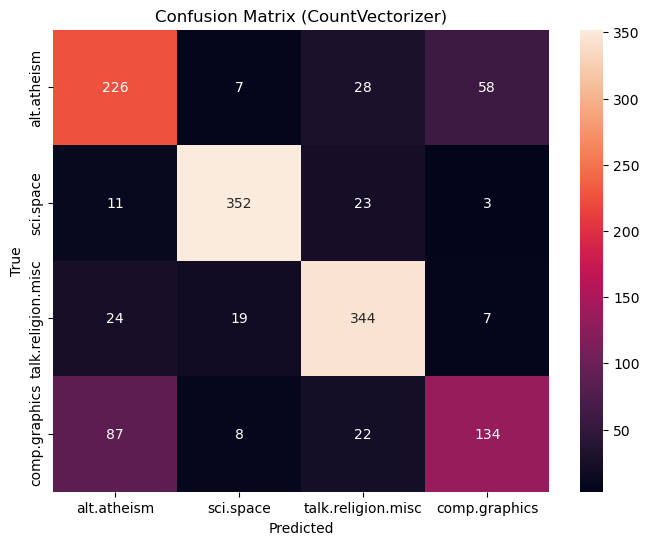

                    precision    recall  f1-score   support

       alt.atheism       0.65      0.71      0.68       319
         sci.space       0.91      0.90      0.91       389
talk.religion.misc       0.82      0.87      0.85       394
     comp.graphics       0.66      0.53      0.59       251

          accuracy                           0.78      1353
         macro avg       0.76      0.76      0.76      1353
      weighted avg       0.78      0.78      0.78      1353



In [5]:
clf = MultinomialNB()
cross_val_scores = cross_val_score(clf, X_train_vec, y_train, cv=5, scoring='accuracy')
print(f"Средняя точность при кросс-валидации: {cross_val_scores.mean():.2f}")

clf.fit(X_train_vec, y_train)

# Confusion matrix
y_pred = clf.predict(X_test_vec)
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=categories, yticklabels=categories)
plt.title('Confusion Matrix (CountVectorizer)')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Classification report
print(classification_report(y_test, y_pred, target_names=categories))

In [ ]:
# Посмотрим на ТОП 10 по важности слова в каждой категории

def show_top10(classifier, vectorizer, categories):
    feature_names = np.asarray(vectorizer.get_feature_names())
    for i, category in enumerate(categories):
        top10 = np.argsort(classifier.coef_[i])[-10:]
        print("%s: [%s]" % (category, " ".join(feature_names[top10])))

show_top10(clf, vec, newsgroups_train.target_names)

alt.atheism: like believe say atheism does just think don people god
sci.space: software images files data use file jpeg edu graphics image
talk.religion.misc: just shuttle time orbit data like earth launch nasa space
comp.graphics: know say christian think just bible don jesus people god


### 2.3 [Tf-IDF](https://ru.wikipedia.org/wiki/TF-IDF)

Мешок слов не учитывает "веса" слов, он просто смотрит их вхождение в документ. Вероятно, было бы полезно взвесить каким-то обраом каждое слово в документе. Действительно, если слово встречается во всех документах, то, наверное, его вес небольшой. А если редкое слово встречается в некоторых документах, то скорее всего оно какое-то узко тематическое.

Один из способов взвесить слова - это использовать меру tf-idf, где:

**TF - term frequency** - частота слова для каждой статьи

$$\LARGE \mathrm{tf}(t,d) = \frac{n_t}{\sum_k n_k}$$

**IDF - inverse document frequency*** — обратная частота документа - уменьшает вес часто встречаемых слов

$$\LARGE \mathrm{idf}(t, D) =  \log \frac{|D|}{|\{\,d_i \in D \mid t \in d_{i}\, \}|}$$

$D$ - число документов в корпусе

$|\{\,d_i \in D \mid t \in d_{i}\, \}|$ - число документов из коллекции ${\displaystyle D}$ , в которых встречается ${\displaystyle t}$  (когда ${\displaystyle n_{t}\neq 0}$ ).

**TF-IDF**

$$\LARGE \operatorname{tf-idf}(t,d,D) = \operatorname{tf}(t,d) \times \operatorname{idf}(t, D)$$


Для него есть класс [sklearn.feature_extraction.text.TfidfVectorizer](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html)

- Проведите кроссвалидацию на 5 фолдах для метрики `accuracy`.
- обучите на тренировочных данных, 
- нарисуйте красивую confusion матрицу, (с именами классов, а не индексами по осям)
- выведите отчет классификации для тестовой выборки (с именами классов, а не индексами)

In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Векторизация текста
vec_tfidf = TfidfVectorizer(stop_words='english')
X_train_tfidf = vec_tfidf.fit_transform(newsgroups_train.data)
X_test_tfidf = vec_tfidf.transform(newsgroups_test.data)

print(f"Размер словаря (TF-IDF): {len(vec_tfidf.get_feature_names_out())}")


Размер словаря (TF-IDF): 26576


In [ ]:
# Обучение модели
clf_tfidf = MultinomialNB()
cross_val_scores_tfidf = cross_val_score(clf_tfidf, X_train_tfidf, y_train, cv=5, scoring='accuracy')
print(f"Средняя точность при кросс-валидации (TF-IDF): {cross_val_scores_tfidf.mean():.2f}")
clf_tfidf.fit(X_train_tfidf, y_train)


Средняя точность при кросс-валидации (TF-IDF): 0.79


MultinomialNB()

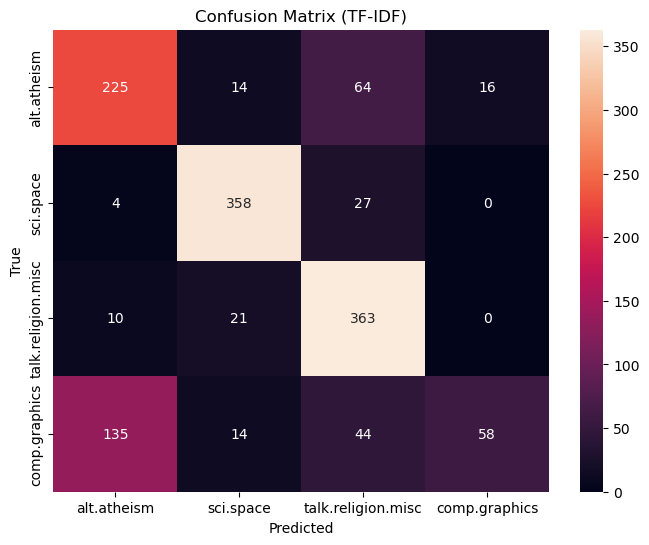

                    precision    recall  f1-score   support

       alt.atheism       0.60      0.71      0.65       319
         sci.space       0.88      0.92      0.90       389
talk.religion.misc       0.73      0.92      0.81       394
     comp.graphics       0.78      0.23      0.36       251

          accuracy                           0.74      1353
         macro avg       0.75      0.69      0.68      1353
      weighted avg       0.75      0.74      0.71      1353



In [13]:
# Confusion matrix
y_pred_tfidf = clf_tfidf.predict(X_test_tfidf)
cm_tfidf = confusion_matrix(y_test, y_pred_tfidf)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_tfidf, annot=True, fmt='d', xticklabels=categories, yticklabels=categories)
plt.title('Confusion Matrix (TF-IDF)')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Classification report
print(classification_report(y_test, y_pred_tfidf, target_names=categories))


In [17]:
show_top10(clf_tfidf, vec_tfidf, newsgroups_train.target_names)

alt.atheism: islam does religion atheism say just think don people god
comp.graphics: windows does looking program know file image files thanks graphics
sci.space: earth think shuttle orbit moon just launch like nasa space
talk.religion.misc: objective think just bible don christians christian people jesus god


In [14]:
show_top10(clf, vec, newsgroups_train.target_names)

alt.atheism: like believe say atheism does just think don people god
comp.graphics: software images files data use file jpeg edu graphics image
sci.space: just shuttle time orbit data like earth launch nasa space
talk.religion.misc: know say christian think just bible don jesus people god


### 2.4 В чём проблема?

Как вы заметили, качество немного улучшилось. Как вы думаете почему у нас до сих пор есть ошибки? В чём проблема? Опирайтесь на вывод топа 10 важных слов, confusion matrix и репорт классификации.

**Задание**: Напишите развернутое рассуждение.

Ответ: 
TF-idf показал себя хуже, потому что:
1. **Редкие слова:** TF-IDF увеличивает вес редких слов, но если такие слова встречаются в нескольких категориях, они могут вносить шум.
2. **Пересечение терминов:** В данных много общих слов (например, "just", "like", "think"), которые TF-IDF может "перевзвесить", что приводит к потере важной информации.
3. **Предположение о независимости признаков:** Naive Bayes предполагает, что признаки (слова) независимы. Однако TF-IDF усиливает зависимость между словами, так как учитывает их частоту в документах и корпусе. Это может ухудшить качество модели.

![](https://i.imgur.com/3D5pgrk.png)

Можно еще немного улучшить качество предсказания, если использовть n-граммы, то есть не только одиночные слова, но и пары, тройки. Для этого у векторайзера есть параметр `ngram_range`, но будьте осторожны, сгенерируется очень много признаков. Их количество можно ограничить  `max_features`. Ещё можно копать в сторону правильного процессинга текстов: лемматизация и стемминг, чтобы убирать окончания, но это обчно не сильно помогает в английском языке.

Кроме того можно было бы пойти совсем в другую сторону и использовать word-2-vec технологии, тогда бы у нас слова начал "обретать" смысл. Но это вовсем другая история.